In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
import matplotlib.patches as patches
from collections import Counter
import matplotlib.patheffects as path_effects

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from highlight_text import ax_text, fig_text
from PIL import Image
from mplsoccer import add_image
import urllib
from urllib.request import urlopen

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("D:\FData\EPL_2023-24\EPL_2023\EPL_2023_2024GW01_to_GW38.csv")

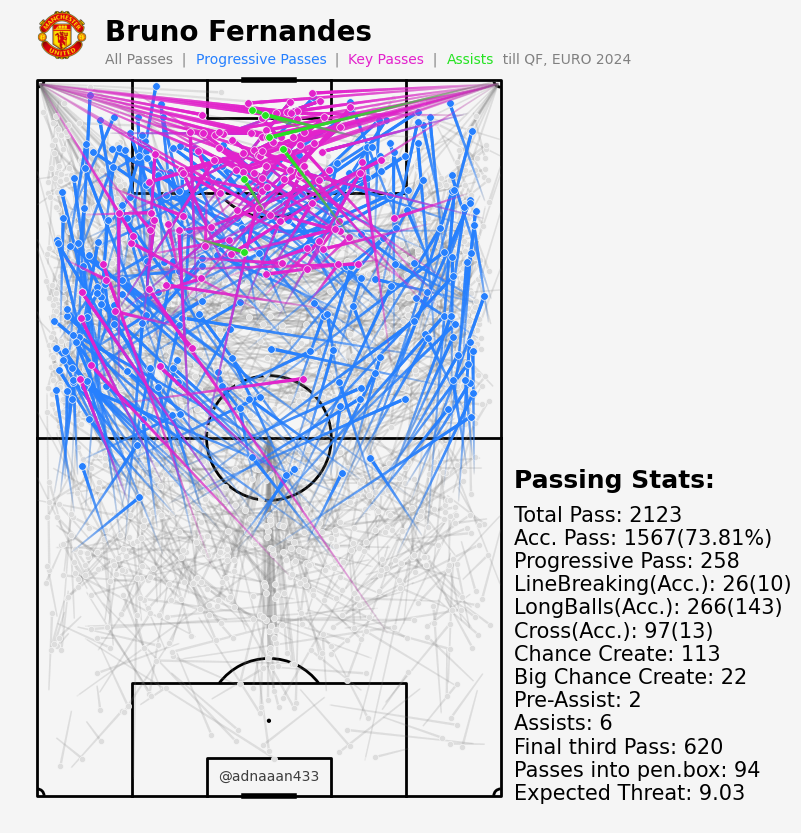

In [16]:
def passmap(ax, pname):
    dfpass = df[(df['type']=='Pass') & (df['name']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
                        (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Thr_ball = dfpass[(dfpass['qualifiers'].str.contains('Throughball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Thr_ball_acc = Thr_ball[Thr_ball['outcomeType']=='Successful']
    Lng_ball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Lng_ball_acc = Lng_ball[Lng_ball['outcomeType']=='Successful']
    Crs_pass = dfpass[(dfpass['qualifiers'].str.contains('Cross')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Crs_pass_acc = Crs_pass[Crs_pass['outcomeType']=='Successful']

    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    df_no_carry = df[df['type']!='Carry']
    df_no_carry = df_no_carry.reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') & (df_no_carry['outcomeType']=='Successful') & 
                  (df_no_carry['name']==pname)]
    assists = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]

    xT = dfpass['xT'].sum().round(2)

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', corner_arcs=True, linewidth=2)
    pitch.draw(ax=ax)

    ap = pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color='#808080', zorder=1, lw=1.75, comet=True, transparent=True, alpha=0.1, ax=ax)
    pp = pitch.lines(pro_pass.x, pro_pass.y, pro_pass.endX, pro_pass.endY, color='#2680ff', zorder=3, lw=2.25, comet=True, transparent=True, ax=ax)
    kp = pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color='#e322cc', zorder=5, lw=2.35, comet=True, transparent=True, ax=ax)
    ass = pitch.lines(assists.x, assists.y, assists.endX, assists.endY, color='#25e322', zorder=7, lw=2.5, comet=True, transparent=True, ax=ax)
    ax.scatter(acc_pass.endY, acc_pass.endX, color='#dddddd', edgecolor='#f5f5f5', linewidth=0.5, s=20, zorder=2)
    ax.scatter(pro_pass.endY, pro_pass.endX, color='#2680ff', edgecolor='#f5f5f5', linewidth=0.5, s=30, zorder=4)
    ax.scatter(key_pass.endY, key_pass.endX, color='#e322cc', edgecolor='#f5f5f5', linewidth=0.5, s=30, zorder=6)
    ax.scatter(assists.endY, assists.endX, color='#25e322', edgecolor='#f5f5f5', linewidth=0.5, s=30, zorder=8)

    ax.text(58, 112, f'{pname}', fontsize=20, fontweight='bold', ha='left', va='center')
    ax_text(58,108, s='All Passes  |  <Progressive Passes>  |  <Key Passes>  |  <Assists>  till QF, EURO 2024', ha='left', va='center', color='#808080',
            highlight_textprops=[{'color':'#2680ff'},{'color':'#e322cc'},{'color':'#25e322'},], ax=ax)
    ax.text(-2, 48, 'Passing Stats:', fontsize=18, fontweight='bold', ha='left', va='top')
    ax.text(-2,46, f'''
Total Pass: {len(dfpass)}
Acc. Pass: {len(acc_pass)}({accurate_pass_perc}%)
Progressive Pass: {len(pro_pass)}
LineBreaking(Acc.): {len(Thr_ball)}({len(Thr_ball_acc)})
LongBalls(Acc.): {len(Lng_ball)}({len(Lng_ball_acc)})
Cross(Acc.): {len(Crs_pass)}({len(Crs_pass_acc)})
Chance Create: {len(key_pass)}
Big Chance Create: {len(big_chnc)}
Pre-Assist: {len(pre_asst)}
Assists: {len(assists)}
Final third Pass: {len(fnl_thd)}
Passes into pen.box: {len(pen_box)}
Expected Threat: {xT}''', ha='left', va='top', fontsize=15)

    ax.text(34, 2.75, '@adnaaan433', ha='center', va='center', alpha=0.75)

    team_name = dfpass['teamName'].unique()
    team_name = team_name[0]
    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    
    ax_coords = DC_to_NFC((68,108))
    ax_size = 0.05
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')

    # ax_coords = DC_to_NFC((-1,52.5))
    # ax_size = 0.36
    # image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='#d9d9d9', anchor='C')
    # fotmob_url = f'file:///D:/FData/Euro2024/Player_Img/{pname}.html'
    # fotmob_url = fotmob_url.replace(' ', '_')
    # club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    # image_ax.imshow(club_icon)
    # image_ax.axis('on')
    # image_ax.set_xticks([])
    # image_ax.set_yticks([])
    # for spine in image_ax.spines.values():
    #     spine.set_visible(False)

    # ax_coords = DC_to_NFC((-45,108))
    # ax_size = 0.05
    # image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    # fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/league_logos/main/EURO2024.png'
    # fotmob_url = fotmob_url.replace(' ', '%20')
    # club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    # image_ax.imshow(club_icon)
    # image_ax.axis('off')
    
    return

fig,ax=plt.subplots(figsize=(10,10), facecolor='#f5f5f5')
passmap(ax, "Bruno Fernandes")

In [9]:
df['position'].unique()

array([nan, 'AMC', 'DMC', 'DR', 'FW', 'MC', 'GK', 'DL', 'FWR', 'DC',
       'FWL', 'AMR', 'AML', 'Sub', 'DML', 'DMR', 'MR', 'ML'], dtype=object)

In [10]:
filtered_df = df[df['position'].notna()]
mids = filtered_df[filtered_df['position'].str.contains('AMC|DMC|MC|DML|DMR|MR|ML')]

unique_names = mids['name'].unique()
# unique_names = unique_names[1::]
sorted_names = sorted(unique_names)
print(sorted_names)
# unique_names

['Aaron Hickey', 'Aaron Ramsey', 'Abdoulaye Doucouré', 'Adam Lallana', 'Adam Wharton', 'Adama Traoré', 'Albert Sambi Lokonga', 'Alejandro Garnacho', 'Alex Iwobi', 'Alex Scott', 'Alexis Mac Allister', 'Alfie Doughty', 'Amad Diallo', 'Amadou Onana', "Amari'i Bell", 'Andre Brooks', 'Andreas Pereira', 'Andros Townsend', 'André Gomes', 'Anis Ben Slimane', 'Ansu Fati', 'Anthony Elanga', 'Anthony Gordon', 'Antoine Semenyo', 'Antony', 'Arnaut Danjuma', 'Ashley Young', 'Auston Trusty', 'Ben Brereton', 'Ben Chilwell', 'Ben Johnson', 'Ben Osborn', 'Benson Manuel', 'Bernardo Silva', 'Billy Gilmour', 'Bobby Clark', 'Bobby De Cordova-Reid', 'Boubacar Kamara', 'Boubacar Traoré', 'Brennan Johnson', 'Bruno Fernandes', 'Bruno Guimarães', 'Bryan Gil', 'Bénie Traoré', 'Callum Hudson-Odoi', 'Calum Chambers', 'Cameron Archer', 'Carlos Baleba', 'Carlton Morris', 'Carney Chukwuemeka', 'Casemiro', 'Cheick Doucouré', 'Cheikhou Kouyaté', 'Chiedozie Ogbene', 'Chris Basham', 'Chris Richards', 'Christian Eriksen', 

In [17]:
def passing_stats_counter(pname):
    dfpass = df[(df['type']=='Pass') & (df['name']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    
    if len(dfpass) != 0:
        accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    else:
        accurate_pass_perc = 0
    
    pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
                        (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Thr_ball = dfpass[(dfpass['qualifiers'].str.contains('Throughball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Thr_ball_acc = Thr_ball[Thr_ball['outcomeType']=='Successful']
    Lng_ball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Lng_ball_acc = Lng_ball[Lng_ball['outcomeType']=='Successful']
    Crs_pass = dfpass[(dfpass['qualifiers'].str.contains('Cross')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Crs_pass_acc = Crs_pass[Crs_pass['outcomeType']=='Successful']
    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    key_pass_op = dfpass[(dfpass['qualifiers'].str.contains('KeyPass')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    big_chnc_op = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated') & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    df_no_carry = df[df['type']!='Carry']
    df_no_carry = df_no_carry.reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') & 
                           (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    assists = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist')]
    assists_op = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist') & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) & 
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    frwd_pass = dfpass[(dfpass['endX']>=dfpass['x']+2) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    back_pass = dfpass[(dfpass['endX']<=dfpass['x']-2) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    frwd_pass_acc = frwd_pass[frwd_pass['outcomeType']=='Successful']
    corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    corners_acc = corners[corners['outcomeType']=='Successful']
    freekik = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    freekik_acc = freekik[freekik['outcomeType']=='Successful']
    thins = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    thins_acc = thins[thins['outcomeType']=='Successful']
    lngball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    lngball_acc = lngball[lngball['outcomeType']=='Successful']

    if len(frwd_pass) != 0:
        Forward_Pass_Accuracy = round((len(frwd_pass_acc)/len(frwd_pass))*100, 2)
    else:
        Forward_Pass_Accuracy = 0
    
    df_xT = dfpass[dfpass['xT']>0]
    
    return {
        'Pass_Attempts': len(dfpass),
        'Pass_Completed': len(acc_pass),
        'Pass_Incomplete': len(dfpass) - len(acc_pass),
        'Pass_Accuracy': accurate_pass_perc,
        'Forward_Pass': len(frwd_pass),
        'Forward_Pass_Completed': len(frwd_pass_acc),
        'Forward_Pass_Accuracy': Forward_Pass_Accuracy,
        'Side_Pass': len(dfpass) - len(frwd_pass) - len(back_pass),
        'Back_Pass': len(back_pass),
        'Progressive_Pass': len(pro_pass),
        'Through_Pass': len(Thr_ball),
        'Through_Pass_Completed': len(Thr_ball_acc),
        'OpenPlay_Cross': len(Crs_pass),
        'OpenPlay_Cross_Completed': len(Crs_pass_acc),
        'OpenPlay_Longballs': len(lngball),
        'OpenPlay_Longballs_Completed': len(lngball_acc),
        'Corners_Taken': len(corners),
        'Corners_Accurate': len(corners_acc),
        'Freekick': len(freekik),
        'Freekick_Accurate': len(freekik_acc),
        'ThrowIns': len(thins),
        'ThrowIns_Accurate': len(thins_acc),
        'Key_Pass': len(key_pass),
        'OpenPlay_KeyPass': len(key_pass_op),
        'Big_Chance_Created': len(big_chnc),
        'OpenPlay_Big_Chance_Created': len(big_chnc_op),
        'Pre_Assist': len(pre_asst),
        'Assists': len(assists),
        'OpenPlay_Assists': len(assists_op),
        'Final_Third_Passes': len(fnl_thd), 
        'Penalty_Box_Passes': len(pen_box),
        'xT_From_Passes': df_xT['xT'].sum().round(2)
    }


pnames = sorted_names

# Create a list of dictionaries to store the counts for each player
data = []

for pname in pnames:
    counts = passing_stats_counter(pname)
    counts['Name'] = pname
    data.append(counts)

# Convert the list of dictionaries to a DataFrame
passing_stats_df = pd.DataFrame(data)

# Sort the DataFrame by 'pr_count' in descending order
passing_stats_df = passing_stats_df.sort_values(by='Progressive_Pass', ascending=False)

# Adding rank columns for each subject
param_columns = passing_stats_df.columns[:-1]  # Exclude the 'name' column

for param in param_columns:
    rank_column = f'{param}_rank'
    passing_stats_df[rank_column] = passing_stats_df[param].rank(ascending=False, method='dense').astype(int)

passing_stats_df

,Pass_Attempts,Pass_Completed,Pass_Incomplete,Pass_Accuracy,Forward_Pass,Forward_Pass_Completed,Forward_Pass_Accuracy,Side_Pass,Back_Pass,Progressive_Pass,Through_Pass,Through_Pass_Completed,OpenPlay_Cross,OpenPlay_Cross_Completed,OpenPlay_Longballs,OpenPlay_Longballs_Completed,Corners_Taken,Corners_Accurate,Freekick,Freekick_Accurate,ThrowIns,ThrowIns_Accurate,Key_Pass,OpenPlay_KeyPass,Big_Chance_Created,OpenPlay_Big_Chance_Created,Pre_Assist,Assists,OpenPlay_Assists,Final_Third_Passes,Penalty_Box_Passes,xT_From_Passes,Name,Pass_Attempts_rank,Pass_Completed_rank,Pass_Incomplete_rank,Pass_Accuracy_rank,Forward_Pass_rank,Forward_Pass_Completed_rank,Forward_Pass_Accuracy_rank,Side_Pass_rank,Back_Pass_rank,Progressive_Pass_rank,Through_Pass_rank,Through_Pass_Completed_rank,OpenPlay_Cross_rank,OpenPlay_Cross_Completed_rank,OpenPlay_Longballs_rank,OpenPlay_Longballs_Completed_rank,Corners_Taken_rank,Corners_Accurate_rank,Freekick_rank,Freekick_Accurate_rank,ThrowIns_rank,ThrowIns_Accurate_rank,Key_Pass_rank,OpenPlay_KeyPass_rank,Big_Chance_Created_rank,OpenPlay_Big_Chance_Created_rank,Pre_Assist_rank,Assists_rank,OpenPlay_Assists_rank,Final_Third_Passes_rank,Penalty_Box_Passes_rank,xT_From_Passes_rank
230,3591,3309,282,92.15,1892,1668,88.16,623,1076,357,14,6,12,0,292,233,3,3,66,66,5,5,50,50,8,8,3,7,7,1001,72,9.38,Rodri,1,1,24,7,1,1,6,2,2,1,7,6,66,25,2,1,53,37,9,5,66,61,19,11,12,10,6,3,2,1,10,4
218,3062,2641,421,86.25,1347,1097,81.44,654,1061,289,4,2,86,27,166,92,131,66,120,81,43,42,99,59,9,5,1,9,8,700,84,12.12,Pascal Groß,2,2,5,42,3,4,28,1,3,2,16,10,7,2,14,11,3,3,1,2,34,32,2,6,11,13,8,1,1,4,4,1
119,2355,2175,180,92.36,1560,1388,88.97,316,479,276,2,0,4,1,135,85,0,0,36,35,6,5,8,8,0,0,2,0,0,252,9,3.94,Jan Paul van Hecke,4,3,75,5,2,2,4,21,36,3,18,12,74,24,25,14,56,40,26,16,65,61,58,51,20,18,7,10,9,68,64,56
265,1642,1143,499,69.61,1059,647,61.10,188,395,261,1,1,106,25,323,115,1,1,20,16,321,229,33,33,6,6,3,7,7,353,60,7.09,Vladimír Coufal,22,31,3,227,8,18,213,59,54,4,19,11,4,3,1,7,55,39,40,34,2,3,33,26,14,12,6,3,2,36,18,13
40,2123,1567,556,73.81,1083,735,67.87,442,598,261,26,10,97,13,268,145,151,76,59,35,21,20,113,75,22,16,2,6,5,628,95,11.54,Bruno Fernandes,8,16,1,193,7,13,148,5,20,4,3,2,5,12,4,3,1,1,11,16,50,47,1,2,1,2,7,4,4,8,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,100,71,29,71.00,45,23,51.11,17,38,3,0,0,1,0,7,1,0,0,0,0,0,0,5,5,0,0,0,0,0,29,5,0.16,Danny Ings,241,231,172,215,212,211,253,174,208,142,20,12,77,25,120,84,56,40,60,50,71,66,61,54,20,18,9,10,9,191,68,215
210,33,29,4,87.88,13,11,84.62,5,15,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,9,1,0.04,Omari Forson,259,247,187,28,228,217,15,184,222,142,20,12,78,25,127,85,56,40,60,50,71,66,65,58,20,18,9,10,9,205,72,220
129,37,26,11,70.27,17,8,47.06,6,14,3,1,1,0,0,1,1,0,0,1,1,0,0,2,2,1,1,0,0,0,5,2,0.32,John Fleck,258,248,184,223,224,219,258,183,223,142,19,11,78,25,126,84,56,40,59,49,71,66,64,57,19,17,9,10,9,207,71,203
35,47,36,11,76.60,15,9,60.00,8,24,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0.03,Bobby Clark,256,245,184,158,226,218,222,181,217,143,20,12,78,25,125,84,56,40,60,50,71,66,66,59,20,18,9,10,9,205,73,221


In [20]:
player = passing_stats_df[passing_stats_df['Name'] == 'Bruno Fernandes'].iloc[0]
player

Pass_Attempts               2123
Pass_Completed              1567
Pass_Incomplete              556
Pass_Accuracy              73.81
Forward_Pass                1083
                           ...  
Assists_rank                   4
OpenPlay_Assists_rank          4
Final_Third_Passes_rank        8
Penalty_Box_Passes_rank        3
xT_From_Passes_rank            3
Name: 40, Length: 65, dtype: object

In [18]:
passing_stats_df.to_csv("D:\FData\EPL_2023-24\EPL_2023\EPL_Passing_Stats_of_Midfielders.csv")